Highest score: 0.656700	

In [11]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score

def read_data_from_csv(path):
    """Load datasets from CSV files.
    Args:
        path (str): Path to the CSV file.
    Returns:
        X (np.ndarray): Features of samples.
        y (np.ndarray): Labels of samples, only provided in the public datasets.
    """
    assert os.path.exists(path), f'File not found: {path}!'
    assert os.path.splitext(path)[
        -1] == '.csv', f'Unsupported file type {os.path.splitext(path)[-1]}!'

    data = pd.read_csv(path)
    column_list = data.columns.values.tolist()

    if 'Label' in column_list:
        # for the public dataset, label column is provided.
        column_list.remove('Label')
        X = data[column_list].values
        y = data['Label'].astype('int').values
        return X, y
    else:
        # for the private dataset, label column is not provided.
        X = data[column_list].values
        return X
    

X_public, y_public = read_data_from_csv('assignment_5_public.csv')
print('Shape of X_public:', X_public.shape)  # n_sample, m_feature (30000, 58)
print('Shape of y_public:', y_public.shape)  # n_sample (30000,)



Shape of X_public: (30000, 58)
Shape of y_public: (30000,)


|   Features                    |    Types	        |       data types      | 
|-------------------------------|-------------------|-----------------------|
|       1-11, 18-29, 38-58      |    Continuous     |       numberic number |
|       12-17, 30-37            |   Categorical     |       boolean(1/0)    |

In [4]:
df_x = pd.DataFrame(X_public)
df_y = pd.DataFrame(y_public)

In [3]:
print(df_y[0].value_counts())

0
1    15978
0    14022
Name: count, dtype: int64


In [6]:
def normalize(df: pd.DataFrame):
    df_norm = df
    # Continuous features   1-11, 18-29, 38-58
    df_1T11 = df_norm.iloc[:, 0:11]  
    df_18T19 = df_norm.iloc[:, 17:29]
    df_38T58 = df_norm.iloc[:, 37:58]

    # Categorical features  12-17, 30-37 
    df_12T17 = df_norm.iloc[:, 11:17]
    df_30T37 = df_norm.iloc[:, 29:37]

    # concatenating along columns
    horizontal_Continuous_concat = pd.concat([df_1T11, df_18T19, df_38T58], axis=1)
    horizontal_Categorical_concat = pd.concat([df_12T17, df_30T37], axis=1)

    # Normalize the numeric features
    scaler = MinMaxScaler()
    normalized_Continuous = pd.DataFrame(scaler.fit_transform(pd.DataFrame(horizontal_Continuous_concat)))

    # change Categorical features data type from float to boolean
    for column in horizontal_Categorical_concat:
        horizontal_Categorical_concat[column] = horizontal_Categorical_concat[column].astype(bool)

    print(horizontal_Continuous_concat.shape)
    print(horizontal_Categorical_concat.shape)
    
    #  combine to full dataset
    df_fullConcat = pd.concat([normalized_Continuous, horizontal_Categorical_concat], axis=1)

    return df_fullConcat

In [7]:
normalized_x = normalize(df_x)


(30000, 44)
(30000, 14)


In [8]:
normalized_x

,0,1,2,3,4,5,6,7,8,9,...,15,16,29,30,31,32,33,34,35,36
0,0.285714,0.022233,0.000745,7.309030e-11,0.000887,0.049342,0.017241,0.085938,0.010989,0.303731,...,False,False,False,True,False,False,False,False,False,False
1,0.285714,0.022706,0.000787,7.217675e-11,0.001143,0.019737,0.034483,0.000000,0.000000,0.271099,...,False,False,False,False,False,True,False,False,False,False
2,0.333333,0.029092,0.000644,7.426417e-11,0.000835,0.029605,0.034483,0.007812,0.000000,0.309443,...,True,False,False,False,False,False,False,False,True,True
3,0.285714,0.015137,0.000901,6.874928e-11,0.001254,0.013158,0.034483,0.007812,0.021978,0.201404,...,False,False,True,False,False,False,False,False,False,False
4,0.571429,0.147706,0.000405,7.876849e-11,0.000689,0.128289,0.060345,0.085938,0.000000,0.309256,...,False,True,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.523810,0.051325,0.000631,7.620845e-11,0.000969,0.013158,0.017241,0.007812,0.010989,0.284189,...,False,False,True,False,False,False,False,False,False,False
29996,0.571429,0.070009,0.000417,7.746878e-11,0.000633,0.029605,0.051724,0.023438,0.000000,0.258694,...,True,False,False,False,False,True,False,False,False,False
29997,0.333333,0.036306,0.000677,7.514986e-11,0.000991,0.019737,0.025862,0.007812,0.010989,0.301023,...,False,False,False,False,False,False,True,False,False,False
29998,0.428571,0.178571,0.000443,7.901729e-11,0.000733,0.095395,0.129310,0.054688,0.000000,0.342777,...,True,False,True,False,False,False,False,False,False,False


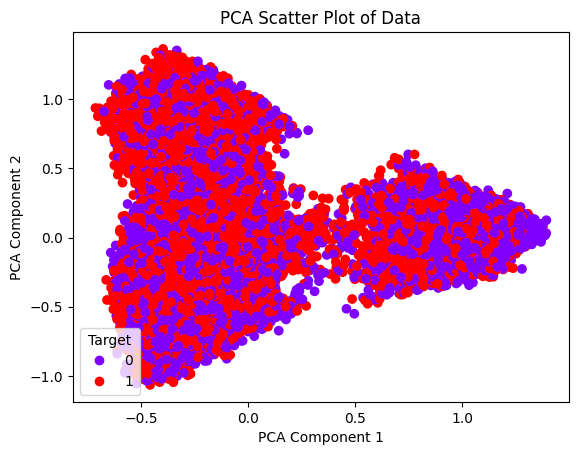

In [14]:
# Create a PCA object with 2 components
pca_2 = PCA(n_components=2)

# Fit the PCA model to the data
pca_2.fit(normalized_x)

# Transform the data into the new 2D space
X_pca = pca_2.transform(normalized_x)

# Plot the scatter graph
fig, ax = plt.subplots()
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c = y_public, cmap='rainbow')

# Add a legend to the plot
legend = ax.legend(*scatter.legend_elements(), loc="lower left", title="Target")

ax.set_title("PCA Scatter Plot of Data")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")

plt.show()

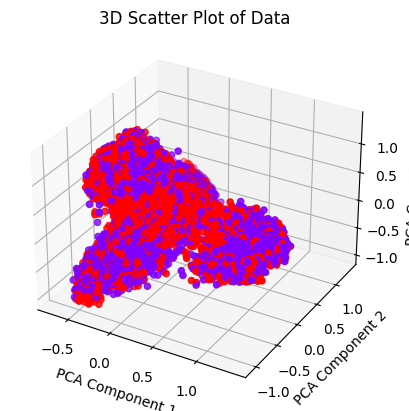

In [16]:
# Create a PCA object with 3 components
pca_3 = PCA(n_components=3)

pca_3.fit(normalized_x)

# Transform the data into the new 3D space
X_pca = pca_3.transform(normalized_x)

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c = y_public, cmap='rainbow')

ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('3D Scatter Plot of Data')

plt.show()